# Expectation Maximization Algorithms

Expectation-Maximization (EM) Algorithms are powerful technique to obtain maximum likelihood estimates in situations where it is difficult to maximize the likelihood directly.*  

This is especially common for latent variable models, which can have very complicated likelihood functions. The canonical example are mixture models, which model the data as generated by a mixture of processes. The result is a likelihood function that has parameters which describe the mixing balance and the parameters of the individual data generating processes. The are usually no convenient expressions for the maximum likelihood estimates of the likelihood function of the complete model, but there may be convenient expressions for the conditional maximum likelihood estimates of individual parameters. The EM algorithm relies on those simpler, conditional expressions, to find an estimate.

The EM Algorithm performs gradient-free coordinate ascent by iterating between an "expectation" and a "maximization" step. Similar to gradient descent, it can be modified to scale to very large datasets by stochastic approximation, producing stochastic EM. Similar to gradient descent, it can be shown that EM is guaranteed to maximize the likelihood, but there is no guaranty that the maximum is global. 

There is a large body of work that optimizes and adapts EM algorithms to a variety of situations. The most important applications of "plain vanilla" EM are latent variable models in which the conditional probability of the latent parameters is tractable. 


*The literature seems to provide no rigorous definition of what is meant by 'difficult'. The best translation seems to be "difficult to write down, and even more difficult to write down the gradient".


## Basic Concept

Given are a set of data and a probability model (likelihood function). The goal is to find the maximum likelihood estimate of the parameters of the probability model. Let's say that the likelihood function of the full model is complicated and unwieldy, but there are convenient ways to find conditional maximum likelihood estimates for two subsets of the model parameters individually. 

Essentially, the EM-Algorithm alternates between updating estimates of those two interlinked sets of parameters. For example in a mixture model, one subset is the mixture parameters and one subset are the parameters of the individual components of the mixture. 

The algorithm is first initialized, and then iterates over two steps: the "expectation" step and the "maximization" step. 

During initialization, the model parameters are set to a reasonable guess.

During the expectation step, the conditional maximum likelihood estimates for one subset of parameters is updated, conditional on the current value assigned to the other subset of parameters during initialization or the M-step. For example, in a mixture model, these are the probabilities of component-membership given a data point and the current guess of the process parameters. (Ex. "Probability $r_{ic}$ that datapoint $x_i$ belongs to cluster $c$ given cluster parameters $\{\mu_j, \Sigma_j \}_{1...c...k}$.)

During the maximization step, the maximum likelihood estimates for the other subset of parameters is updated, using the probabilities calculated for the remaining parameters during the E-step. For example, in a mixture model, these are the maximum likelihood estimates of the process parameters given the probabilities of the mixture parameters during the previous steps. (Ex. "Maximum likelihood estimates of $\mu_c$ and $\Sigma_c$ of cluster $c$ given the probabilities $r_{ic}$ that datapoint $x_i$ belongs to cluster $c$.)


## References

### Best references: 

Textbook (in context of maximum likelihood inference):
    Wasserman, "All of Statistics" (2003), page 143

Blog Post (NVIDIA) (best insight in theory; explains variational EM):
    https://chrischoy.github.io/research/Expectation-Maximization-and-Variational-Inference/
    

### Video Lectures
Andrew Ng Lecture (1:20hrs)
    https://www.youtube.com/watch?v=rVfZHWTwXSA


Much shorter Introductory Video Lecture (17 mins)
    https://www.youtube.com/watch?v=qMTuMa86NzU


### Blog Post
Application to Image Processing
    https://towardsdatascience.com/solving-a-chicken-and-egg-problem-expectation-maximization-em-c717547c3be2

Gaussian Mixture Models
    https://towardsdatascience.com/latent-variables-expectation-maximization-algorithm-fb15c4e0f32c
    
Blog Post, which explains things well but the code is wrong:
    https://www.python-course.eu/expectation_maximization_and_gaussian_mixture_models.php
    


## Implementation

Implements a Gaussian Mixture Model that is fitted through the EM Algorithm. 

In [331]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = 0

from time import time

import numpy as np
from scipy.stats import multivariate_normal


def timer(fun):
    def wrapper_fun(*args,**kwargs):
        t0 = time()
        res = fun(*args,**kwargs)
        print("%s ran %1.3fs" % (str(fun),time()-t0))
        return res
    
    return wrapper_fun
    
    
    
class GMM(object):
    """
    Gaussian Mixture Model fitted using the Expectation Maximization Algorithm
    """
    
    def __init__(self,n_clusters=3):
        self.n_clusters = n_clusters
        
    
    def fit(self,X,iters=100):
        """
        Initialize & Iterate
        """
        print("%i data points in %i dimensional space" % X.shape)
        
        self.X = X
        self.log_likelihoods = []
        
        # initialize 
        # cluster index: c
        self.mu = np.vstack([
            np.random.uniform(low=min(self.X[:,i]),high=max(self.X[:,i]),size=self.n_clusters) 
            for i in range(self.X.shape[1])
        ]).T # format: mu_c = self.mu[c]
        
        
        self.var = np.vstack([
            np.diag(np.var(self.X,axis=0)/self.n_clusters).reshape(1,self.X.shape[1],self.X.shape[1]) 
            for c in range(self.n_clusters)
        ]) # format: var_c = self.var[c]
        
        self.pi = np.random.uniform(low=0,high=1,size=self.n_clusters)
        self.pi = self.pi / np.sum(self.pi,axis=0) # format: pi_c = self.pi_c[c]
        
        
        self.gaussian = [
            multivariate_normal(mean=self.mu[c],cov=self.var[c],allow_singular=True) 
            for c in range(self.n_clusters)
        ] # format: p_c = gaussian[c]
        
        
        for i in range(iters):
            self.iterate()
        
    
    def E_step(self):
        """
        'Expectation' Step
        
        Calculate the maximum likelihood values of the latent variable conditional on data & process parameters
        
        For GMM, these are the conditional probabilities of a cluster label
        """
        
        r_ = np.vstack(list(map(
            lambda x: [self.pi[c]*self.gaussian[c].pdf(x) for c in range(self.n_clusters)],
            self.X
        ))).T
        
        self.r = r_/np.sum(r_,axis=0) # format: r_c = self.r[c]
        
        assert self.r.shape == (self.n_clusters,self.X.shape[0])
    

    def M_step(self):
        """
        'Maximization' Step
        
        Calculate the maximum likelihood estimates of process parameters
        
        For GMM, these are the means and variances of the clusters and cluster probabilities
        """
        
        self.mu = np.vstack([
            np.sum(self.r[c] * self.X.T, axis=1).T/np.sum(self.r[c])
            for c in range(self.n_clusters)
        ])
        
        assert self.mu.shape == (self.n_clusters,self.X.shape[1])
        
        
        def var_(r_c,mu_c):
            
            eps = np.sqrt(r_c)*(self.X-mu_c).T
            var = np.dot(eps,eps.T)
            
            assert var.shape == (X.shape[1],X.shape[1])
            
            return var
        
        self.var = np.vstack([
            (var_(self.r[c],self.mu[c])/np.sum(self.r[c])).reshape(1,self.X.shape[1],self.X.shape[1]) 
            for c in range(self.n_clusters)
        ])
            
        
        self.pi = [
            np.mean(self.r[c]) 
            for c in range(self.n_clusters)
        ]
        
        
        self.gaussian = [
            multivariate_normal(mean=self.mu[c],cov=self.var[c],allow_singular=True) 
            for c in range(self.n_clusters)
        ] # format: p_c = gaussian[c]
        
        
    def likelihood(self,x):
        return np.sum([self.pi[c]*self.gaussian[c].pdf(x) for c in range(self.n_clusters)])
    
    @timer
    def iterate(self):
        self.E_step()
        self.M_step()

(987, 2)
987 data points in 2 dimensional space
Likelihood:	 1.4790546154749624
<function GMM.iterate at 0x130938170> ran 0.086s
Likelihood:	 35.21453212806358
<function GMM.iterate at 0x130938170> ran 0.082s
Likelihood:	 35.20790685036597
<function GMM.iterate at 0x130938170> ran 0.084s
Likelihood:	 35.21459851699403
<function GMM.iterate at 0x130938170> ran 0.084s
Likelihood:	 35.245456347790665
<function GMM.iterate at 0x130938170> ran 0.084s
Likelihood:	 35.300571861041064
<function GMM.iterate at 0x130938170> ran 0.084s
Likelihood:	 35.38252712182005
<function GMM.iterate at 0x130938170> ran 0.084s
Likelihood:	 35.49736773138143
<function GMM.iterate at 0x130938170> ran 0.082s
Likelihood:	 35.654897306200354
<function GMM.iterate at 0x130938170> ran 0.090s
Likelihood:	 35.86933409144123
<function GMM.iterate at 0x130938170> ran 0.085s
Likelihood:	 36.15868816859468
<function GMM.iterate at 0x130938170> ran 0.165s
Likelihood:	 36.54052366818098
<function GMM.iterate at 0x130938170>

Text(0.5, 1.0, 'GMM Model')

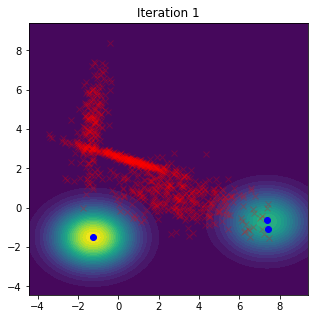

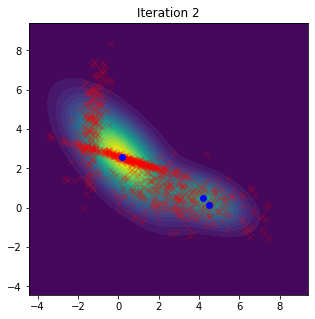

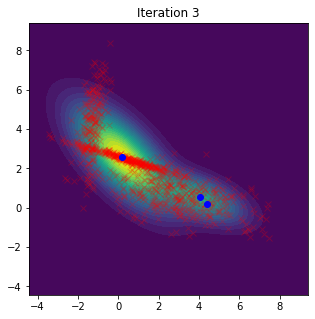

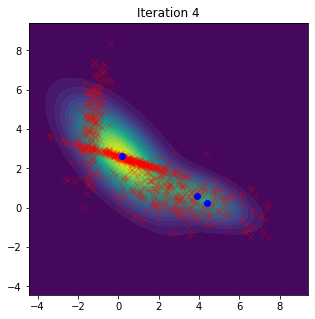

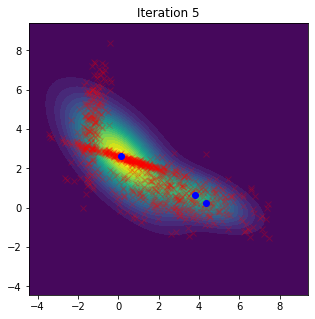

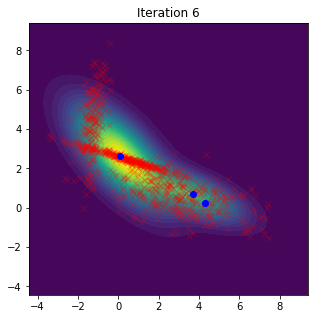

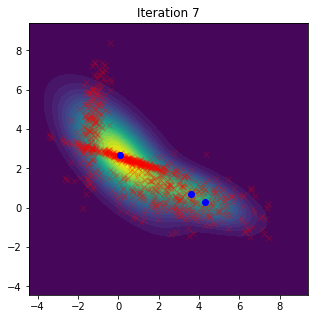

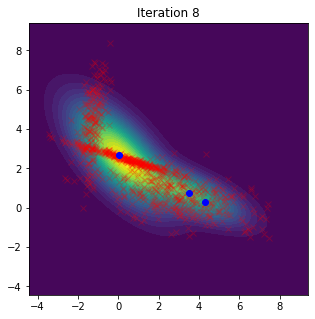

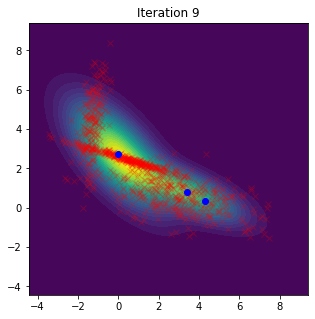

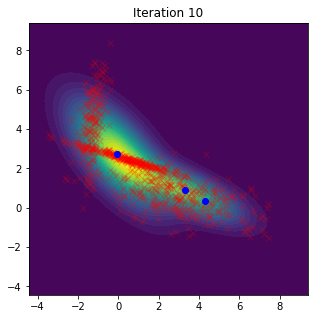

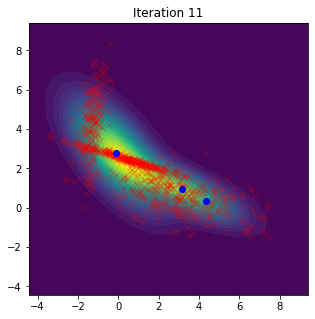

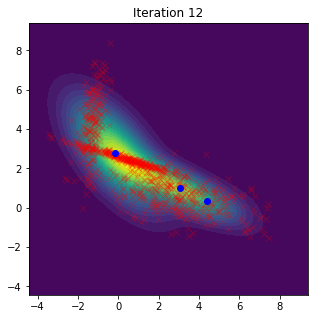

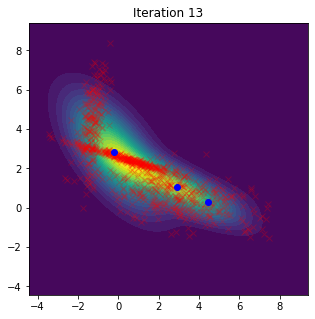

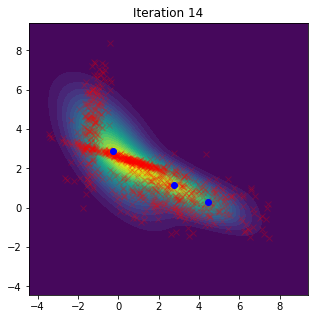

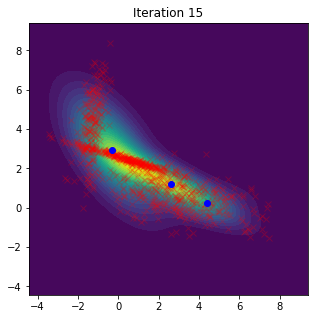

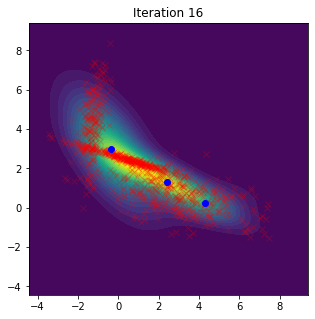

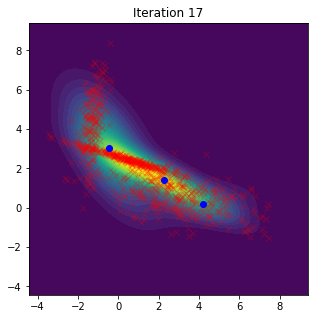

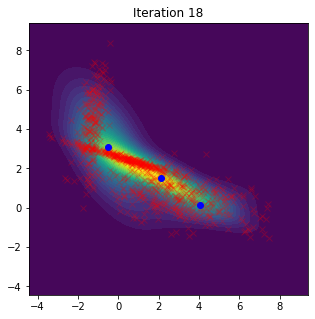

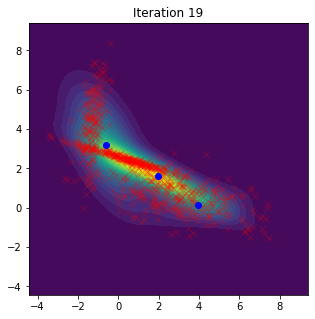

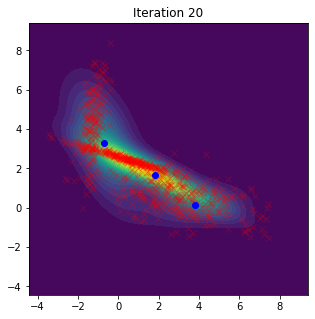

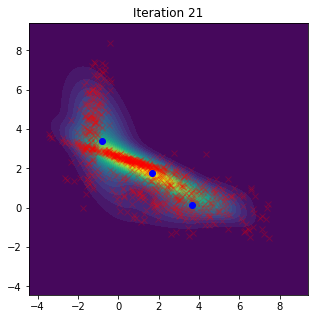

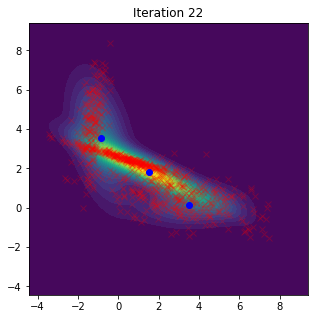

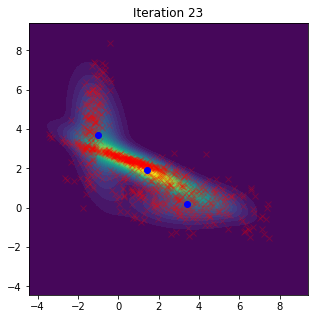

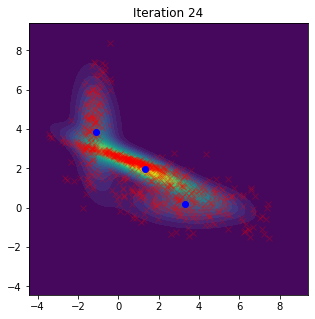

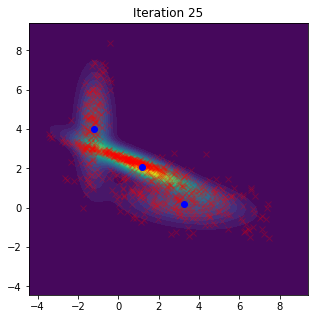

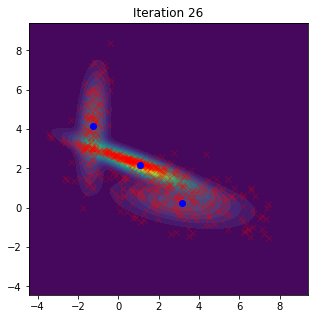

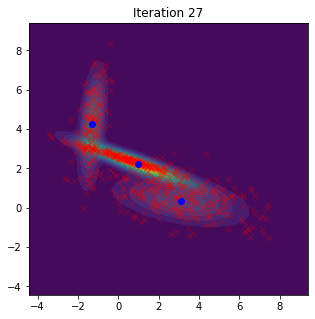

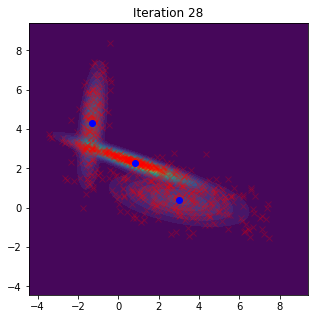

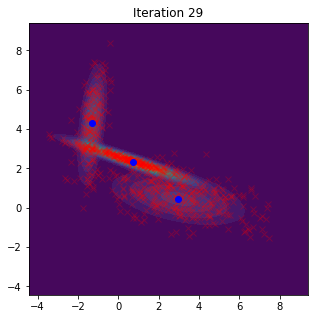

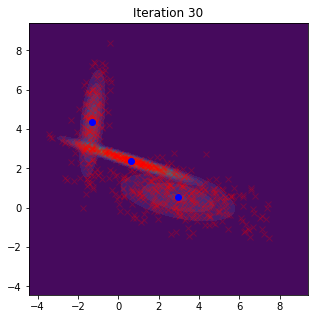

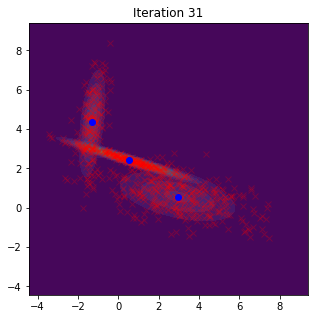

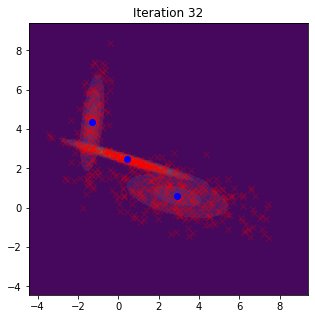

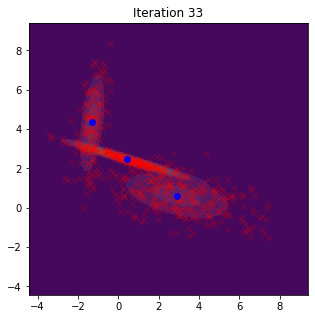

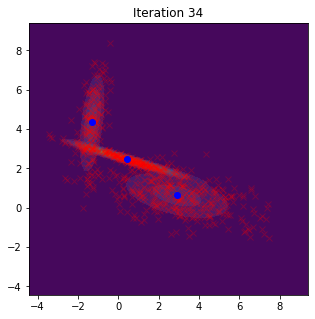

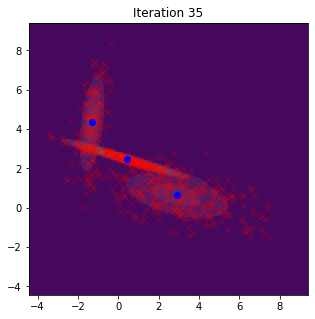

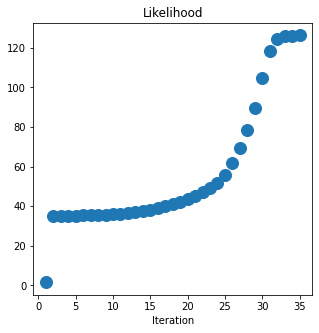

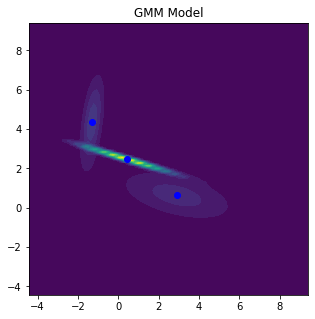

In [355]:
# for pathological case (local minimum) select 45
np.random.seed(42)

"""
Make Data
"""
X = np.vstack([
    np.random.uniform(low=-5,high=5,size=2) + np.dot(np.random.randn(np.random.randint(low=100,high=500),2),np.random.randn(2,2)) 
    for c in range(3)
])
print(X.shape)


"""
Fit GMM
"""

likelihood = []
gmm = GMM(3)
gmm.fit(X,iters=0)

for i in range(35):
    x,y = np.meshgrid(np.linspace(np.min(X)-1,np.max(X)+1,100),np.linspace(np.min(X)-1,np.max(X)+1,100))
    z = np.array([gmm.likelihood(c) for c in zip(x.flatten(),y.flatten())]).reshape(*x.shape)

    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()
    ax.contourf(x,y,np.log(z+1),levels=25)
    ax.plot(X[:,0],X[:,1],'x',alpha=0.25,color='red')
    ax.plot(gmm.mu[:,0],gmm.mu[:,1],'o',color='blue')
    ax.set_title('Iteration %i' % (i+1))
    
    likelihood.append(np.sum(list(map(gmm.likelihood,X))))
    print("Likelihood:\t",likelihood[-1])

    gmm.iterate()

    
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.plot(range(1,len(likelihood)+1),likelihood,'o',markersize=12)
ax.set_title('Likelihood')
ax.set_xlabel('Iteration')

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.contourf(x,y,np.log(z+1),levels=25)
ax.plot(gmm.mu[:,0],gmm.mu[:,1],'o',color='blue')
ax.set_title('GMM Model')